In [1]:
import sys
import os
sys.path.append("/home/phi.richter/SOFTWARE_PHD/run_RRTMG_OOP")
import rrtmg as FLUXES
import numpy as np

In [2]:
## Profiles
z = np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/z.csv", delimiter=",")
co2 = np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/co2.csv", delimiter=",")
o3 = np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/o3.csv", delimiter=",")
ch4 = np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/ch4.csv", delimiter=",")
n2o = np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/n2o.csv", delimiter=",")

In [3]:
import netCDF4 as nc
with nc.Dataset("/mnt/beegfs/user/phi.richter/REMOVE/ERA5/ozone.nc", "r") as f:
    o3 = f.variables['o3'][:]
    z_era5 = f.variables['z'][:]/9.80665*1e-3
    lat = np.argmin(np.abs(np.array(f.variables['latitude'][:])-81.95))
    lon = np.argmin(np.abs(np.array(f.variables['longitude'][:])-10.33))
print(lat, lon)

12 81


/home/conda/envs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/home/conda/envs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd

In [4]:
import scipy.interpolate
o3_f = scipy.interpolate.interp1d(np.array(z_era5[0,:,12,81]), np.array(o3[0,:,12,81]), fill_value="extrapolate")
o3 = o3_f(np.array(z))

In [5]:
o3

array([1.50331316e-08, 1.48546813e-08, 1.46847285e-08, 1.44722876e-08,
       1.42598467e-08, 1.40474059e-08, 1.38349650e-08, 1.36225241e-08,
       1.35800359e-08, 1.36330443e-08, 1.65466633e-08, 1.94602823e-08,
       2.23739013e-08, 3.69419963e-08, 5.15100913e-08, 5.73373293e-08,
       7.19054243e-08, 7.50226894e-08, 7.89712375e-08, 8.13403664e-08,
       8.17220283e-08, 8.17604282e-08, 8.18065082e-08, 8.25502069e-08,
       8.37538766e-08, 8.57322934e-08, 8.79473406e-08, 8.90635058e-08,
       8.89272266e-08, 8.79789800e-08, 8.69303568e-08, 8.68897517e-08,
       8.72658883e-08, 8.76497175e-08, 9.10108799e-08, 9.78669211e-08,
       1.02281495e-07, 1.06696070e-07, 1.10969413e-07, 1.12769660e-07,
       1.15470030e-07, 1.18689596e-07, 1.22418377e-07, 1.26397435e-07,
       1.31912645e-07, 1.37427855e-07, 1.43606820e-07, 1.50250504e-07,
       1.56894187e-07, 1.62106486e-07, 1.66974538e-07, 1.71842589e-07,
       1.95659367e-07, 2.23657104e-07, 2.73704593e-07, 3.96924905e-07,
      

In [6]:
import datetime as dt
def open_era5(fname, key):
    with nc.Dataset(fname) as f:
        time = f.variables['time'][:]
        latitude = f.variables['latitude'][:]
        longitude = f.variables['longitude'][:]
        cc = f.variables[key][:]
    return [time, latitude, longitude, cc]

def interpolate_era5_single(data, lat, lon, tim):
    '''
    Find nearest value of given key in ERA5 single level file
    '''
    tim = (tim - dt.datetime(1900, 1, 1)).total_seconds()/3600
    time = data[0]
    latitude = data[1]
    longitude = data[2]
    value = data[3]
    lat_min = np.abs(latitude - lat)
    lon_min = np.abs(longitude - lon)
    time_min = np.abs(time - tim)
    argmin_lat = np.argmin(lat_min)
    argmin_lon = np.argmin(lon_min)
    argmin_time = np.argmin(time_min)
    ret_val = value[argmin_time, argmin_lat, argmin_lon]
    return ret_val

PATH_RADIATION = "/home/phi.richter/ERA5_radiation.nc"

era5_msdwswrfcs = open_era5(PATH_RADIATION, 'msdwswrfcs')
era5_msnswrfcs  = open_era5(PATH_RADIATION, 'msnswrfcs')

/home/conda/envs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/home/conda/envs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/home/conda/envs/testing/lib/python3.7/site-packages/ipykern

In [7]:
path_retrievals = "/mnt/beegfs/user/phi.richter/DATA_PHD/RRTMG/INPUT/INPUT_FOR_RRTMG/RRTMG_input_nomod"
ssp_ice = "./"
ssp_wat = "./"
files = sorted(os.listdir(path_retrievals))

In [8]:
path_rrtmg = "/home/phi.richter/SOFTWARE_PHD/run_RRTMG_OOP"
model = FLUXES.RRTMG(path_rrtmg+"/rrtmg_lw_v5.00_linux_pgi", path_rrtmg+"/rrtmg_sw_v5.00_linux_pgi", \
                  [ssp_wat, ssp_ice])

in_CNET_20170606_204444_81.950648_10.539039_73.62477298934044.nc


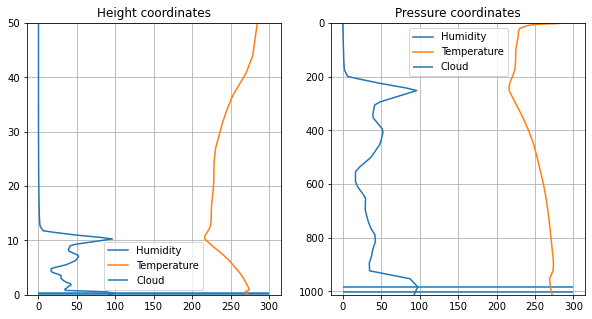

{'LWP(gm-2)': array([0.      , 4.983024]), 'IWP(gm-2)': array([0.78935552, 0.90700806]), 'rliq(um)': array([ 5.        , 11.74656987]), 'rice(um)': array([48.08694839, 47.57210986]), 'clt': array([1., 1.]), 'red_chi_2': array(None, dtype=object)}
{'Latitude': masked_array(data=81.950648,
             mask=False,
       fill_value=1e+20), 'Longitude': masked_array(data=10.539039,
             mask=False,
       fill_value=1e+20), 'SZA': masked_array(data=73.62477299,
             mask=False,
       fill_value=1e+20), 'Time': datetime.datetime(2017, 6, 6, 20, 44, 44)}


In [9]:
epsilon = 0.99*np.ones(16)
epsilon[np.array([5,6,7])] = 0.98
spec = files[10000]
print(spec)
#atm_file = "/mnt/beegfs/user/phi.richter/ERA5_atm_interpolated/ERA5"+spec.split("in_CNET")[1].split(".nc")[0]+".csv"
model.read_cloudnet(os.path.join(path_retrievals, spec))#, pattern_fname="ERA5_%Y%m%d_%H%M%S.nc")
model.plot_atmosphere()
print(model.get_cparam())
atm = model.get_atmosphere()
model.scale('cwp', 10)
model.scale('lwp', 10)
model.scale('iwp', 10)
print(model.get_position())
#model.replace_atmosphere(atm_file)
#model.plot_atmosphere()

In [10]:
lat = float(model.get_position()['Latitude'])
lon = float(model.get_position()['Longitude'])
tim = model.get_position()['Time']

In [11]:
model.get_cloud()['albedo']

0.7294713847124832

In [12]:
msdwswrfcs = interpolate_era5_single(era5_msdwswrfcs, lat, lon, tim)
msnswrfcs = interpolate_era5_single(era5_msnswrfcs, lat, lon, tim)

In [13]:
alb_clear = 1 - msnswrfcs/msdwswrfcs

In [14]:
o3_ppmv = 0.*np.ones(z.size)#np.ones(z.size)#28.9644 / 47.9982 * 1e6 * o3
co2 = np.zeros(z.size)
n2o = np.zeros(z.size)
ch4 = np.zeros(z.size)
tg = model.read_trace_gases(z, co2, n2o, ch4, o3_ppmv)
#model.plot_atmosphere()

In [17]:
epsilon = 0.99*np.ones(16)
atm = "H444444"#"HAAA4A4"
epsilon[np.array([7,8,9,10])] = 0.98
model.temp_half_levels()
in_cld_rrtm = model.create_inputfile_cloud()
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=0, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=False)
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=2, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=True)
input_rrtm = model.create_inputfile_atm_solar(cloud=0, atm=atm, aerosols=0, albedo=[alb_clear], use_albedo_par=False)
#input_aer = model.create_inputfile_aerosols_solar(level=[1], aot=[0.05], num_aer=1, iaod=0, issa=0, ipha=0, aerpar=[0.13, 1.0, 0.0], ssa=[0.780], phase=[0.7])
model.run_RRTMG_solar(clouds=False)
input_rrtm = model.create_inputfile_atm_solar(cloud=2, atm=atm, aerosols=0)
model.run_RRTMG_solar(clouds=True)

In [18]:
model.get_fluxes_solar(30)['clear']

,LEVEL,PRESSURE,UPWARD FLUX,DIFDOWN FLUX,DIRDOWN FLUX,DOWNWARD FLUX,NET FLUX,HEATING RATE
0,73.0,1.0,215.5967,0.0000,374.8811,374.8811,159.284373,0.00000
1,72.0,2.0,215.5786,0.0916,372.1159,372.2075,156.628907,22.40986
2,71.0,3.0,215.5837,0.1744,370.6779,370.8522,155.268571,11.48007
3,70.0,5.0,215.6272,0.3335,368.8680,369.2015,153.574260,7.14927
4,69.0,7.0,215.6803,0.4889,367.5803,368.0692,152.388851,5.00192
...,...,...,...,...,...,...,...,...
69,4.0,923.6,197.4091,44.5027,236.5547,281.0574,83.648330,0.51879
70,3.0,953.1,197.3753,45.3523,233.0410,278.3932,81.017952,0.75248
71,2.0,983.7,197.5975,46.2043,228.9511,275.1554,77.557895,0.95425
72,1.0,1001.0,197.7261,46.6870,226.8279,273.5148,75.788758,0.86301
